# Capture the Flag (RL - Policy Gradient)

- Seung Hyun Kim
- skim449@illinois.edu

## Notes
- This notebook includes:
    - Building the structure of policy driven network.
    - Training with/without render
    - Saver that save model and weights to ./model directory
    - Writer that will record some necessary datas to ./logs
- This notebook does not include running the CtF game with the RL policy. Using the network will be separately scripted in policy/policy_RL1.py.
    - cap_test.py is changed appropriately.
    
## References :
- https://github.com/awjuliani/DeepRL-Agents/blob/master/Vanilla-Policy.ipynb (source)
- https://www.youtube.com/watch?v=PDbXPBwOavc
- https://github.com/lilianweng/deep-reinforcement-learning-gym/blob/master/playground/policies/actor_critic.py (source)

In [1]:
!rm -rf logs/B1R2_AC_MonteCarlo/ model/B1R2_AC_MonteCarlo

In [2]:
TRAIN_NAME='B1R2_AC_MonteCarlo'
LOG_PATH='./logs/'+TRAIN_NAME
MODEL_PATH='./model/' + TRAIN_NAME
GPU_CAPACITY=0.125 # gpu capacity in percentage

In [3]:
import os

import tensorflow as tf
import tensorflow.contrib.slim as slim
import tensorflow.contrib.layers as layers
from tensorflow.python.client import device_lib
import matplotlib.pyplot as plt
%matplotlib inline

import time
import gym
import gym_cap
import gym_cap.envs.const as CONST
import numpy as np
import random

# the modules that you can use to generate the policy.
import policy.patrol 
import policy.random
import policy.simple # custon written policy
import policy.policy_RL
import policy.zeros

# Data Processing Module
from DataModule import one_hot_encoder, VISION_dX, VISION_dY
from Utils import MovingAverage as MA
from Utils import Experience_buffer, discount_rewards

In [4]:
#device_lib.list_local_devices()

## Hyperparameters

In [5]:
# Replay Variables
total_episodes = 100000 #Set total number of episodes to train agent on.
max_ep = 150
update_frequency = 64
mini_batch = 64
batch_size = 2500
experience_size=50000

# Saving Related
save_network_frequency = 1000
save_stat_frequency = 10
moving_average_step = 10

# Training Variables
LEARNING_RATE_FIX = False
LEARNINGRATE_ACTOR  = 1e-4
LEARNINGRATE_CRITIC = 1e-3
LR_ACTOR_DECAY = 0.995
LR_CRITIC_DECAY = 0.995
LR_ACTOR_FINAL = 1e-5
LR_CRITIC_FINAL = 1e-5
gamma = 0.98
discount_factor = 0.98

## Environment Setting

In [6]:
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    
#Create a directory to save episode playback gifs to
if not os.path.exists(LOG_PATH):
    os.makedirs(LOG_PATH)

In [7]:
env = gym.make("cap-v0") # initialize the environment
policy_red = policy.random.PolicyGen(env.get_map, env.get_team_red)
action_space = 5
n_agent = len(env.get_team_blue)
print('red number : ', len(env.get_team_red))
print('blue number : ', len(env.get_team_blue))

red number :  2
blue number :  1


## Policy Network

In [8]:
class agent():
    def __init__(self, lr_actor, lr_critic, in_size, action_size, grad_clip_norm):
        # Parameters
        self.grad_clip_norm = grad_clip_norm
        
        # Learning Rate Variables
        if LEARNING_RATE_FIX:
            self.learning_rate_actor = tf.constant(lr_actor, tf.float32, name='learning_rate_actor')
            self.learning_rate_critic = tf.constant(lr_critic, tf.float32, name='learning_rate_critic')
        else:
            self.learning_rate_actor = tf.placeholder(tf.float32, shape=None, name='learning_rate_actor')
            self.learning_rate_critic = tf.placeholder(tf.float32, shape=None, name='learning_rate_critic')
        
        # Placeholders
        with tf.name_scope('holders'):
            self.state_input = tf.placeholder(shape=in_size,dtype=tf.float32, name='state')
            self.action_holder = tf.placeholder(shape=[None],dtype=tf.int32)
            self.action_OH = tf.one_hot(self.action_holder, action_size)
            self.reward_holder = tf.placeholder(shape=[None],dtype=tf.float32)
            self.target_value_holder = tf.placeholder(shape=[None], dtype=tf.float32, name='target')
            self.advantage_holder = tf.placeholder(shape=[None], dtype=tf.float32, name='adv')            

        
        # Feed-Forward Network
        layer = slim.conv2d(self.state_input, 16, [5,5],# activation_fn=tf.nn.relu,
                            weights_initializer=layers.xavier_initializer_conv2d(),
                            biases_initializer=tf.zeros_initializer(),
                            padding='SAME',
                            scope='conv_1')
        #layer = slim.avg_pool2d(layer, [2,2])
        layer = slim.conv2d(layer, 16, [3,3],# activation_fn=tf.nn.relu,
                            weights_initializer=layers.xavier_initializer_conv2d(),
                            biases_initializer=tf.zeros_initializer(),
                            padding='SAME',
                            scope='conv_2')
        self.layer = slim.flatten(layer)
        #adv_stream, val_stream = tf.split(layer, num_or_size_splits=2)
        
        # Actor stream
        actor = layers.fully_connected(self.layer, 128,
                                    activation_fn=tf.nn.relu,
                                    scope='actor_1')
        self.actor = layers.fully_connected(actor, action_size,
                                    activation_fn=None,
                                    scope='actor_2')
        self.actor_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='conv')+tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='actor')
        print('Actor Network')
        for var in self.actor_vars:
            print(var)
        self.output = tf.nn.softmax(self.actor, name='action')

        # Value stream
        self.critic = layers.fully_connected(self.layer, 1,
        #self.critic = slim.fully_connected(self.layer, 1,
                                    activation_fn=None,
                                    scope='critic_1')
        self.critic = tf.reshape(self.critic, [-1])
        self.critic_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='conv') + tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope='critic')
        print('Critic Network')
        for var in self.critic_vars:
            print(var)
        
        # Feed Backward
        # - compute the  loss, and use it to find gradient, and update the network
        # - May be need to add bootstrap value at the end of the value
        with tf.variable_scope('critic_train'):
            self.loss_critic = tf.reduce_mean(tf.square(self.target_value_holder - self.critic))
            self.optimizer_critic = tf.train.AdamOptimizer(self.learning_rate_critic)
            self.grads_critic = self.optimizer_critic.compute_gradients(self.loss_critic, self.critic_vars)
            if self.grad_clip_norm:
                self.grads_critic = [(tf.clip_by_norm(grad, self.grad_clip_norm), var) for grad, var in self.grads_critic]
            self.grad_holders_critic = [(tf.Variable(var, trainable=False, dtype=tf.float32, name=var.op.name+'_buffer'), var) for var in self.critic_vars]
            self.update_critic = self.optimizer_critic.apply_gradients(self.grad_holders_critic)

        with tf.variable_scope('actor_train'):
            self.entropy = -tf.reduce_mean(self.output * tf.log(self.output), name='entropy')
            self.responsible_outputs = tf.reduce_sum(self.output * self.action_OH, [1])
            self.loss_actor = -tf.reduce_sum(tf.log(self.responsible_outputs)*self.advantage_holder)
            #self.responsible_outputs2 = tf.nn.sparse_softmax_cross_entropy_with_logits(logits=self.actor, labels=self.action_holder)
            #self.loss_actor = tf.reduce_mean(self.responsible_outputs*self.advantage_holder)#+0.01*self.entropy
            self.optimizer_actor = tf.train.AdamOptimizer(self.learning_rate_actor)
            self.grads_actor = self.optimizer_actor.compute_gradients(self.loss_actor, self.actor_vars)
            if self.grad_clip_norm:
                self.grads_actor = [(tf.clip_by_norm(grad, self.grad_clip_norm), var) for grad, var in self.grads_actor]
            self.grad_holders_actor = [(tf.Variable(var, trainable=False, dtype=tf.float32, name=var.op.name+'_buffer'), var) for var in self.actor_vars]
            self.update_actor = self.optimizer_actor.apply_gradients(self.grad_holders_actor)
            #self.update_actor = self.optimizer_actor.apply_gradients(self.grads_actor)
            
        with tf.name_scope('Loss'):
            self.loss = 0.01*self.loss_critic + self.loss_actor - self.entropy * 0.001
            #self.loss = self.loss_critic + self.loss_actor
            
        with tf.name_scope('update'):
            self.accumulate_gradient = tf.group([tf.assign_add(a[0],b[0]) for a,b in zip(self.grad_holders_actor, self.grads_actor)],
                                                [tf.assign_add(a[0],b[0]) for a,b in zip(self.grad_holders_critic, self.grads_critic)])
            self.clear_batch = tf.group([tf.assign(a[0],a[0]*0.0) for a in self.grad_holders_actor],
                                        [tf.assign(a[0],a[0]*0.0) for a in self.grad_holders_critic])
            self.update_batch = tf.group(self.update_actor, self.update_critic)
            
        # Summary
        # Histogram output
        with tf.variable_scope('debug_parameters'):
            tf.summary.histogram('output', self.output)
            tf.summary.histogram('actor', self.actor)
            tf.summary.histogram('critic', self.critic)        
            tf.summary.histogram('action', self.action_holder)
        
        # Graph summary Loss
        with tf.variable_scope('summary'):
            tf.summary.scalar(name='actor_loss', tensor=self.loss_actor)
            tf.summary.scalar(name='critic_loss', tensor=self.loss_critic)
            tf.summary.scalar(name='total_loss', tensor=self.loss)
            tf.summary.scalar(name='Entropy', tensor=self.entropy)
        
        with tf.variable_scope('weights_bias'):
            # Histogram weights and bias
            for var in slim.get_model_variables():
                tf.summary.histogram(var.op.name, var)
                
        with tf.variable_scope('gradients'):
            # Histogram Gradients
            for var, grad in zip(self.actor_vars, self.grads_actor):
                tf.summary.histogram(var.op.name+'/grad_actor', grad[0])
            for var, grad in zip(self.critic_vars, self.grads_critic):
                tf.summary.histogram(var.op.name+'/grad_critic', grad[0])
        
        with tf.variable_scope('Learning_Rate'):
            # Learning Rate
            tf.summary.scalar(name='actor_lr', tensor=self.learning_rate_actor)
            tf.summary.scalar(name='critic_lr', tensor=self.learning_rate_critic)

In [9]:
tf.reset_default_graph() # Clear the Tensorflow graph.
myAgent = agent(lr_actor=LEARNINGRATE_ACTOR, lr_critic=LEARNINGRATE_CRITIC,
                in_size=[None,VISION_dX,VISION_dY,6],action_size=5, grad_clip_norm=50) #Load the agent.
with tf.variable_scope('global_step'):
    global_step = tf.Variable(0, trainable=False, name='global_step') # global step
    increment_global_step_op = tf.assign(global_step, global_step+1)
merged = tf.summary.merge_all()

Actor Network
<tf.Variable 'conv_1/weights:0' shape=(5, 5, 6, 16) dtype=float32_ref>
<tf.Variable 'conv_1/biases:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv_2/weights:0' shape=(3, 3, 16, 16) dtype=float32_ref>
<tf.Variable 'conv_2/biases:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'actor_1/weights:0' shape=(7056, 128) dtype=float32_ref>
<tf.Variable 'actor_1/biases:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'actor_2/weights:0' shape=(128, 5) dtype=float32_ref>
<tf.Variable 'actor_2/biases:0' shape=(5,) dtype=float32_ref>
Critic Network
<tf.Variable 'conv_1/weights:0' shape=(5, 5, 6, 16) dtype=float32_ref>
<tf.Variable 'conv_1/biases:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'conv_2/weights:0' shape=(3, 3, 16, 16) dtype=float32_ref>
<tf.Variable 'conv_2/biases:0' shape=(16,) dtype=float32_ref>
<tf.Variable 'critic_1/weights:0' shape=(7056, 1) dtype=float32_ref>
<tf.Variable 'critic_1/biases:0' shape=(1,) dtype=float32_ref>


## Session

In [10]:
# Launch the session
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=GPU_CAPACITY, allow_growth=True)

sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
#sess = tf.Session()

ma_reward = MA(moving_average_step)
ma_length = MA(moving_average_step)
ma_captured = MA(moving_average_step)

# Setup Save and Restore Network
saver = tf.train.Saver(tf.global_variables())
writer = tf.summary.FileWriter(LOG_PATH, sess.graph)

ckpt = tf.train.get_checkpoint_state(MODEL_PATH)
if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
    saver.restore(sess, ckpt.model_checkpoint_path)
    print("Load Model : ", ckpt.model_checkpoint_path)
else:
    sess.run(tf.global_variables_initializer())
    print("Initialized Variables")

Initialized Variables


In [ ]:
def record(summary_):
    with tf.device('/cpu:0'): 
        summary = tf.Summary()
        summary.value.add(tag='Records/mean_reward', simple_value=ma_reward())
        summary.value.add(tag='Records/mean_length', simple_value=ma_length())
        summary.value.add(tag='Records/mean_succeed', simple_value=ma_captured())
        writer.add_summary(summary, sess.run(global_step))
        
        #summary_str = sess.run(merged,feed_dict={myAgent.state_input:obs})
        writer.add_summary(summary_, sess.run(global_step))
        
        writer.flush()

In [ ]:
def policy_rollout(EXPLORE=False, DETERMINISTIC=True):
    # Run single episode, return the results
    s = env.reset(map_size=20, policy_red=policy_red)
    #obs = one_hot_encoder(s, env.get_team_blue) # partial observation
    obs_next = one_hot_encoder(env._env, env.get_team_blue)
    
    ep_history = []
    indv_history = [[] for _ in range(len(env.get_team_blue))]
    was_alive = [ag.isAlive for ag in env.get_team_blue]
    
    prev_reward=0
    total_reward = 0
    frame=0
    for frame in range(max_ep+1):
        obs = obs_next
        
        if not EXPLORE:
            with tf.device('/cpu:0'):
                act_prob = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
            if DETERMINISTIC:
                act = np.argmax(act_prob, axis=1).tolist()
            else:
                #Probabilistically pick an action given our network outputs.
                act = [np.random.choice(action_space, p=act_prob[x]/sum(act_prob[x])) for x in range(n_agent)] # divide by sum : normalize
        else:
            act = np.random.randint(5,size=n_agent).tolist()

        s,r1,d,_ = env.step(act) #Get our reward for taking an action given a bandit.

        r = r1-prev_reward
        #if r >=1 and r < 100: # ignore capturing
        #    r = 0
        if frame == max_ep and d == False:
            r = -100
            r1 = -100
        total_reward += r
        
        if d:
            value = np.array([0.0 for _ in range(n_agent)])
        else:
            obs_next = one_hot_encoder(env._env, env.get_team_blue) # Full Observation
            value = sess.run(myAgent.critic, feed_dict={myAgent.state_input:obs_next})
        
        # Push history for individual that 'was' alive previous frame
        # [state, action, reward(later:discount), value, advantage(later)]
        for idx, agent in enumerate(env.get_team_blue):
            if was_alive[idx]:
                indv_history[idx].append([obs[idx],act[idx],r,value[idx],0])
      
        # State Transition
        prev_reward = r1
        was_alive = [ag.isAlive for ag in env.get_team_blue]
        
        if d:
            break
    # Policy rollout for all agents are done.
    # Calculate Advantage for individual histories
    for idx, history in enumerate(indv_history):
        if len(history)==0:
            continue
        _history = np.array(history)
        values = np.array(_history[:,3])
        values_ext = np.asarray(values.tolist() + [total_reward])
        advantages = _history[:,2] + gamma * values_ext[1:] - values_ext[:-1]
        advantages = discount_rewards(advantages,discount_factor)
        rewards = _history[:,2]
        _history[:,2] = discount_rewards(rewards,discount_factor)
        _history[:,4] = advantages
        ep_history.extend(_history)
            
    if len(ep_history) > 0:        
        ep_history = np.stack(ep_history)
    
    return [frame, ep_history, r1, env.blue_win, total_reward]

## Training

In [ ]:
if __name__=='__main__':
    ep = sess.run(global_step)
    pre_train = 10 # train critic network to adjust to env.
    exp_buffer = Experience_buffer(experience_shape=5)
    batch_history = []
    try:
        progbar = tf.keras.utils.Progbar(total_episodes,width=5)
        sess.run(myAgent.clear_batch)
        while ep < total_episodes+1:
            # Run episode
            frame, history, reward, did_won, total_reward = policy_rollout(EXPLORE=ep < pre_train,DETERMINISTIC=False)

            # Add history
            exp_buffer.add(history)

            if len(exp_buffer) > 0:
                batch_history = exp_buffer.flush()
                feed_dict={myAgent.learning_rate_actor :LEARNINGRATE_ACTOR,
                           myAgent.learning_rate_critic:LEARNINGRATE_CRITIC,
                           myAgent.reward_holder:batch_history[:,2],
                           myAgent.action_holder:batch_history[:,1],
                           myAgent.state_input:np.stack(batch_history[:,0]),
                           myAgent.target_value_holder:batch_history[:,2],#np.array([total_reward for _ in range(len(batch_history))]),
                           myAgent.advantage_holder:batch_history[:,4]}
                with tf.device('/gpu:0'):
                    sess.run(myAgent.accumulate_gradient, feed_dict=feed_dict)
                
            if ep % mini_batch == 0 and ep != 0:
                with tf.device('/gpu:0'):
                    if ep < pre_train:
                        sess.run(myAgent.update_critic, feed_dict=feed_dict)
                    else:
                        sess.run(myAgent.update_batch, feed_dict=feed_dict)
                    sess.run(myAgent.clear_batch)

            # decay lr
            if not LEARNING_RATE_FIX:
                if ep > pre_train: LEARNINGRATE_ACTOR  = max(LEARNINGRATE_ACTOR*LR_ACTOR_DECAY,LR_ACTOR_FINAL)
                LEARNINGRATE_CRITIC = max(LEARNINGRATE_CRITIC*LR_CRITIC_DECAY,LR_CRITIC_FINAL)
            
            # summarize and record
            ma_reward.append(reward)
            ma_length.append(frame)
            ma_captured.append(env.blue_win)   
            
            if ep % save_stat_frequency == 0 and ep != 0 and len(batch_history) > 0:
                summary_ = sess.run(merged, feed_dict=feed_dict)
                record(summary_)

            # save weight
            if ep % save_network_frequency == 0 and ep != 0:
                saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)

            # Proceed to next episode
            ep += 1
            progbar.update(ep) # update progress bar
            sess.run(increment_global_step_op)

    except KeyboardInterrupt:
        print('\n\nManually stopped the training (KeyboardInterrupt)');
        saver.save(sess, MODEL_PATH+'/ctf_policy.ckpt', global_step=global_step)
        print("save: ", sess.run(global_step), 'episodes')

 62047/100000 [==>..] - ETA: 6:25:04

[[0.47467604 0.01751068 0.23062961 0.03920679 0.23797688]]


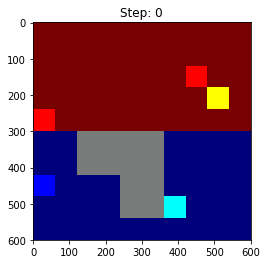

[[0.47730866 0.0171209  0.22335652 0.0454681  0.23674576]]


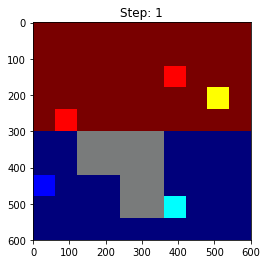

[[0.46263826 0.01683173 0.22777349 0.04348663 0.24926986]]


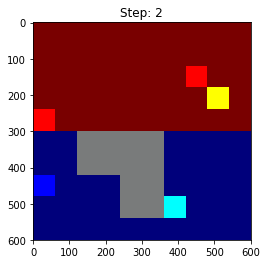

[[0.47730866 0.0171209  0.22335652 0.0454681  0.23674576]]


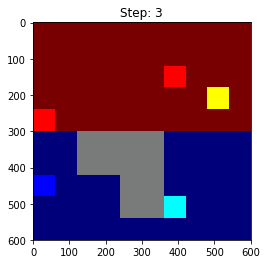

[[0.46457297 0.01716135 0.21996568 0.04658371 0.2517163 ]]


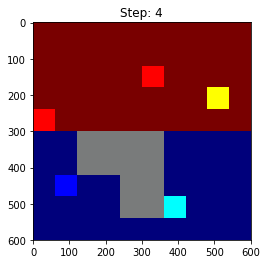

[[0.47405124 0.01268368 0.29226264 0.04880392 0.17219849]]


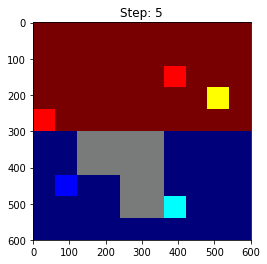

[[0.4854304  0.01235271 0.27838507 0.04860073 0.1752311 ]]


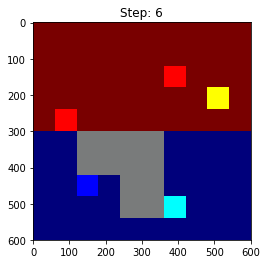

[[0.41690272 0.01169374 0.3878732  0.04649074 0.1370395 ]]


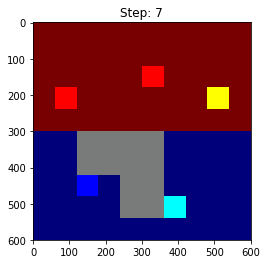

[[0.4113479  0.01154023 0.38632077 0.04733825 0.14345287]]


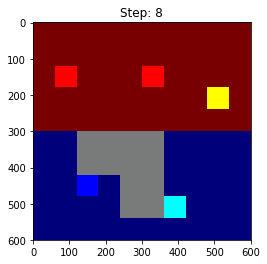

[[0.4148577  0.01225813 0.39298984 0.04370998 0.13618432]]


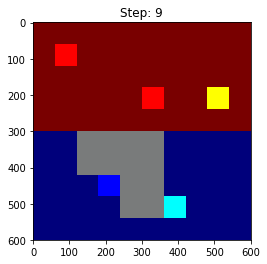

[[0.46484274 0.01054595 0.37699276 0.04702557 0.10059291]]


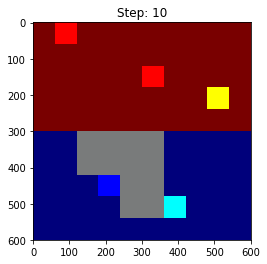

[[0.44393307 0.01026359 0.39638057 0.04047228 0.1089505 ]]


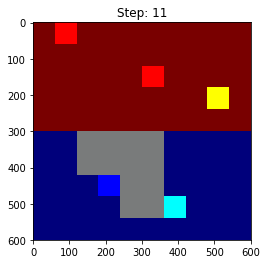

[[0.44393307 0.01026359 0.39638057 0.04047228 0.1089505 ]]


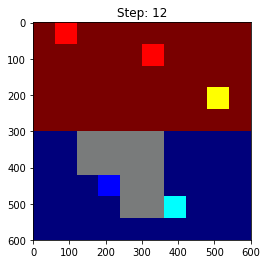

[[0.449407   0.01103887 0.38929942 0.03903486 0.11121982]]


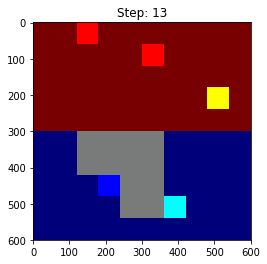

[[0.44841418 0.0112775  0.38365704 0.04290391 0.11374744]]


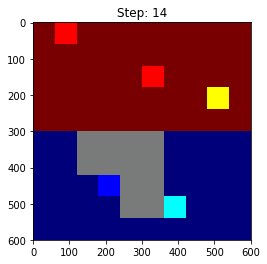

[[0.44393307 0.01026359 0.39638057 0.04047228 0.1089505 ]]


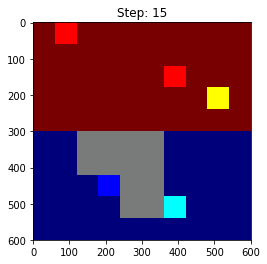

[[0.4395483  0.01083614 0.3979084  0.03987895 0.11182822]]


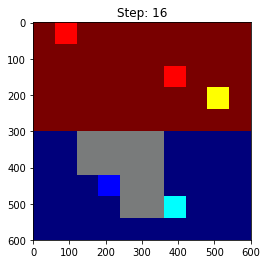

[[0.4395483  0.01083614 0.3979084  0.03987895 0.11182822]]


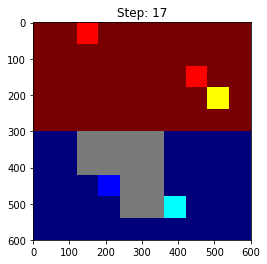

[[0.43497705 0.01144675 0.39702278 0.04419378 0.11235964]]


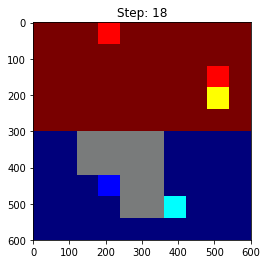

[[0.43803447 0.01162001 0.39247036 0.04263475 0.1152404 ]]


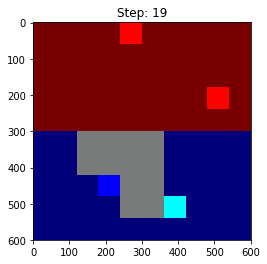

[[0.4457313  0.0101559  0.3911247  0.04216948 0.11081863]]


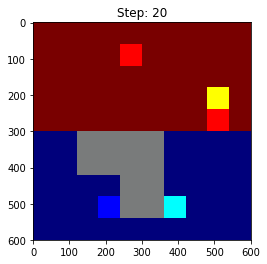

[[0.44751048 0.01427955 0.2972445  0.13961658 0.10134886]]


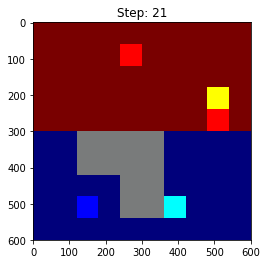

[[0.4606365  0.01683133 0.28151008 0.12756057 0.11346154]]


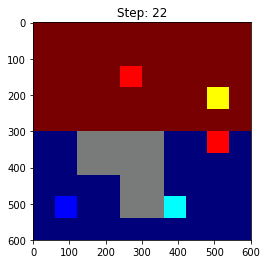

[[0.45118108 0.02263135 0.25675046 0.12940736 0.14002974]]


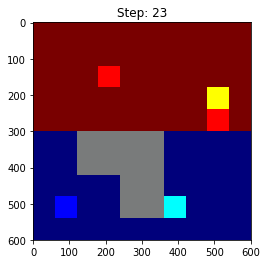

[[0.44965625 0.02266435 0.2542892  0.13242792 0.1409623 ]]


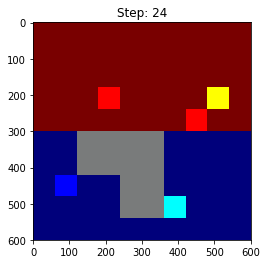

[[0.47185233 0.01246253 0.28977358 0.05138658 0.17452501]]


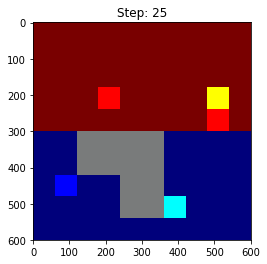

[[0.47784522 0.01278903 0.29134303 0.05029438 0.1677284 ]]


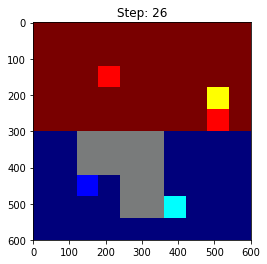

[[0.40091863 0.01113147 0.39642012 0.04493257 0.14659719]]


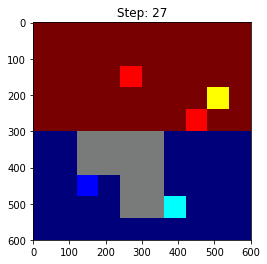

[[0.41904426 0.01126035 0.3836829  0.04472325 0.14128916]]


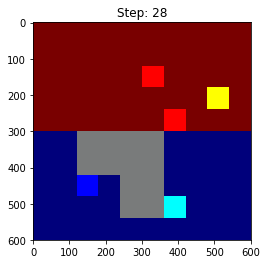

[[0.40412065 0.01137572 0.3897604  0.04378791 0.15095529]]


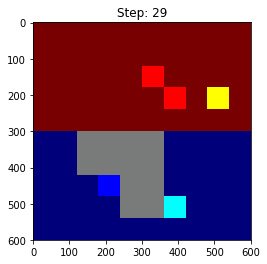

[[0.44960284 0.01039199 0.38328874 0.04802594 0.10869049]]


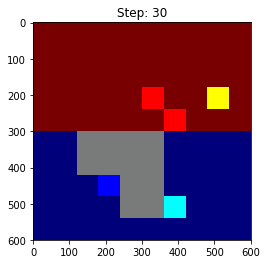

[[0.45370167 0.0101202  0.37813976 0.05104461 0.10699378]]


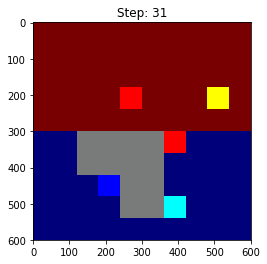

[[0.4389548  0.00972498 0.39543894 0.04489276 0.11098859]]


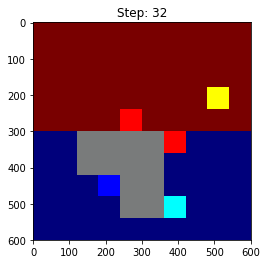

[[0.44125065 0.00990371 0.3916189  0.04833389 0.10889281]]


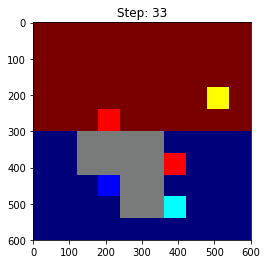

[[0.43752256 0.00995269 0.39246538 0.0500366  0.11002285]]


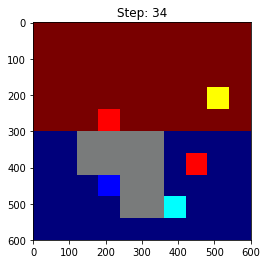

[[0.4449086  0.00993486 0.38749644 0.05076915 0.10689095]]


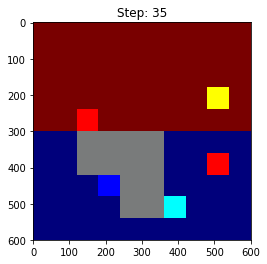

[[0.45532396 0.00998356 0.38154623 0.0466966  0.1064496 ]]


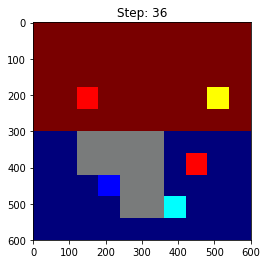

[[0.4512003  0.01016056 0.3820364  0.05104893 0.10555375]]


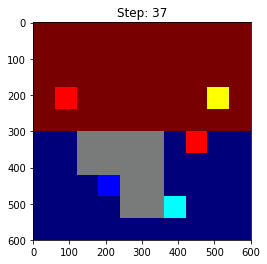

[[0.44767478 0.01019917 0.3930267  0.04577517 0.10332415]]


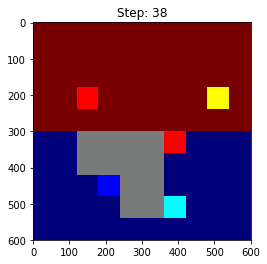

[[0.4444655  0.00995318 0.3861506  0.05044577 0.10898487]]


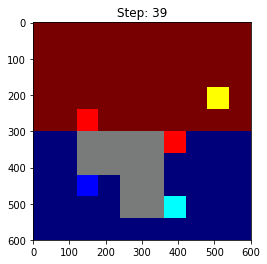

[[0.40152618 0.01085055 0.39845598 0.04771819 0.14144911]]


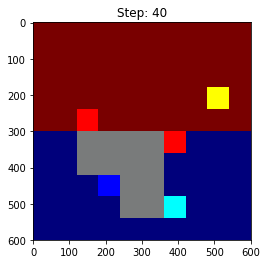

[[0.4525698  0.0097942  0.38000914 0.04847168 0.1091552 ]]


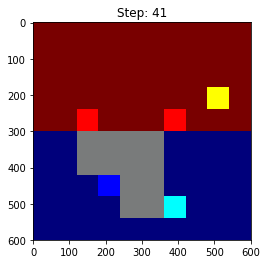

[[0.4563465  0.00988577 0.37098432 0.0516985  0.11108487]]


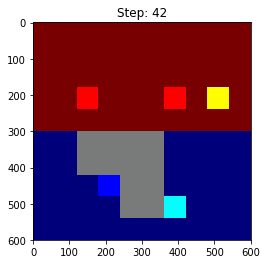

[[0.45196325 0.01061717 0.3750593  0.05283479 0.10952547]]


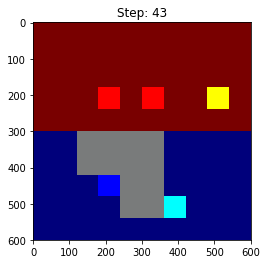

[[0.46176085 0.01051673 0.37738127 0.05127346 0.09906774]]


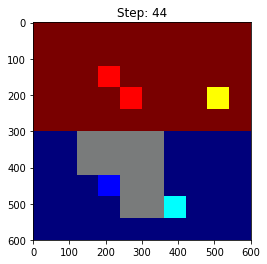

[[0.43523833 0.01037181 0.3971337  0.04477878 0.11247736]]


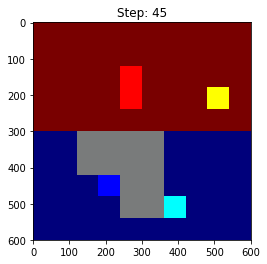

[[0.42604876 0.01006224 0.41065803 0.04418021 0.10905075]]


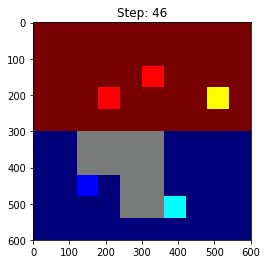

[[0.40303564 0.01132937 0.39716926 0.04322826 0.14523742]]


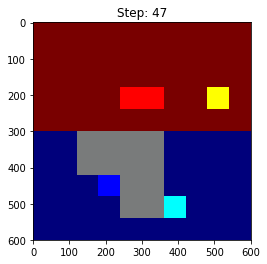

[[0.4455073  0.01036442 0.39090103 0.04772881 0.1054984 ]]


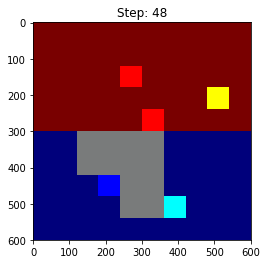

[[0.4347214  0.00989905 0.39981845 0.04608418 0.1094769 ]]


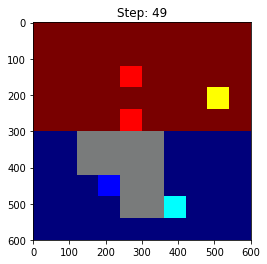

[[0.43195698 0.01029257 0.401632   0.04747234 0.10864606]]


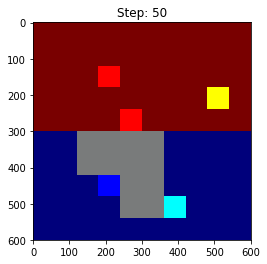

[[0.43915966 0.01048718 0.39107305 0.04837904 0.11090099]]


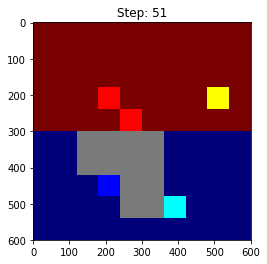

[[0.45204636 0.01042453 0.3822292  0.05133347 0.10396641]]


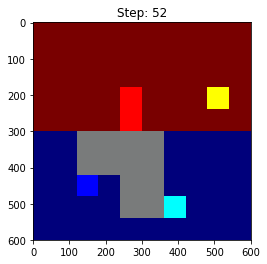

[[0.420052   0.01093944 0.38427547 0.04798327 0.13674974]]


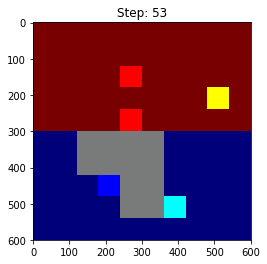

[[0.43195698 0.01029257 0.401632   0.04747234 0.10864606]]


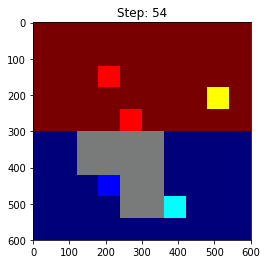

[[0.43915966 0.01048718 0.39107305 0.04837904 0.11090099]]


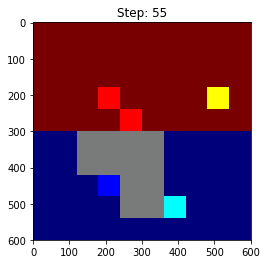

[[0.45204636 0.01042453 0.3822292  0.05133347 0.10396641]]


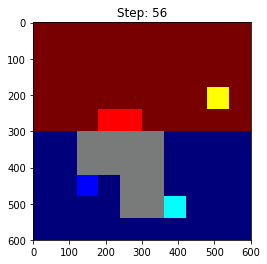

[[0.41483536 0.01079156 0.38493294 0.04821114 0.141229  ]]


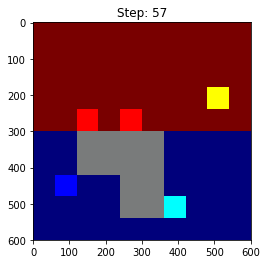

[[0.46698394 0.01208847 0.2936377  0.05272189 0.17456803]]


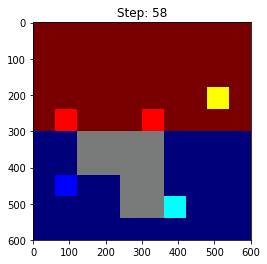

[[0.44968203 0.01199722 0.30071184 0.0525811  0.18502785]]


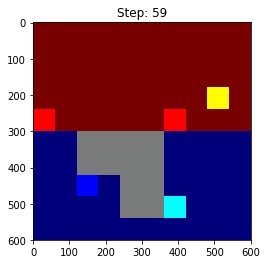

[[0.4184391  0.01066695 0.37945604 0.04656468 0.14487326]]


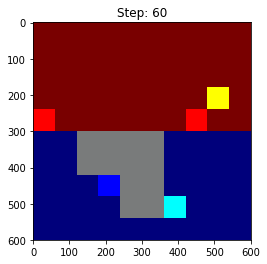

[[0.43978173 0.00980223 0.3887146  0.04965777 0.11204369]]


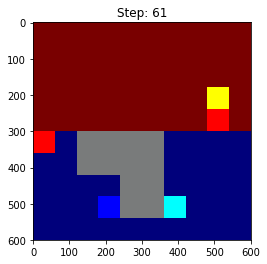

[[0.44891518 0.01398247 0.2919749  0.14704399 0.09808347]]


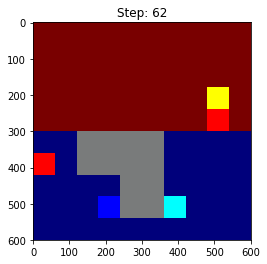

[[0.4524356  0.01423574 0.28848618 0.14822122 0.09662125]]


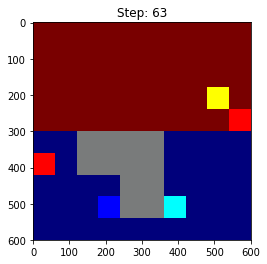

[[0.44758698 0.0148835  0.28017932 0.15389313 0.10345712]]


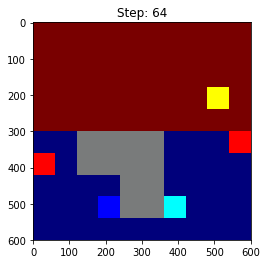

[[0.45612854 0.01427518 0.28312144 0.14483948 0.10163537]]


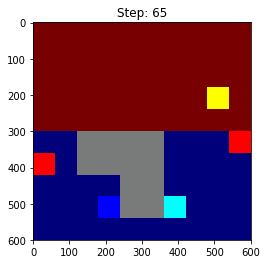

[[0.45612854 0.01427518 0.28312144 0.14483948 0.10163537]]


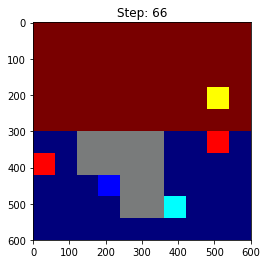

[[0.45102498 0.00972774 0.38675338 0.04497714 0.10751683]]


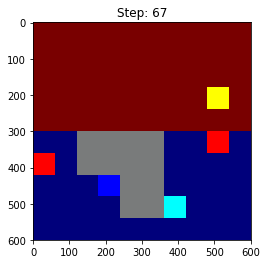

[[0.45102498 0.00972774 0.38675338 0.04497714 0.10751683]]


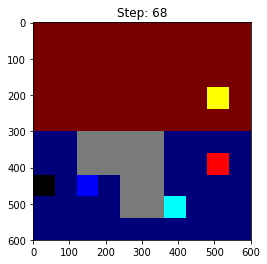

[[0.41040778 0.01062951 0.39411247 0.04160719 0.14324296]]


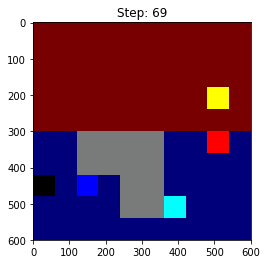

[[0.40975595 0.01058194 0.39733768 0.04337544 0.13894896]]


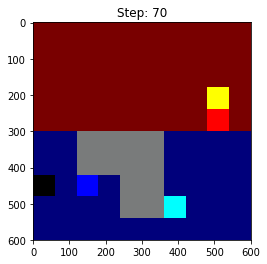

[[0.4141607  0.01105722 0.3834664  0.04432008 0.1469956 ]]


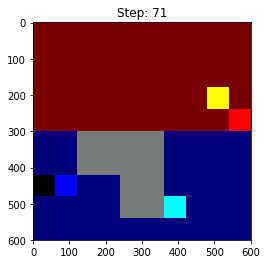

[[0.4631614  0.01127844 0.30358306 0.04552499 0.17645212]]


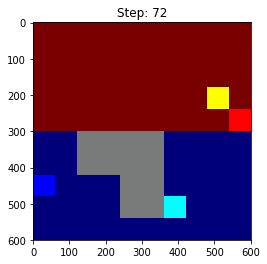

[[0.47964042 0.01611614 0.22912169 0.0411082  0.23401357]]


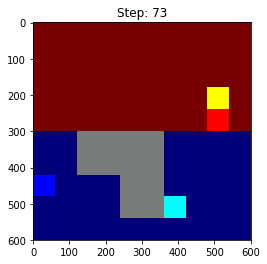

[[0.47540808 0.01628187 0.23042472 0.03851625 0.2393691 ]]


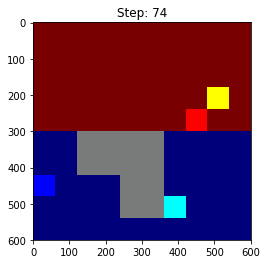

[[0.47636324 0.01709966 0.22677185 0.03923769 0.24052748]]


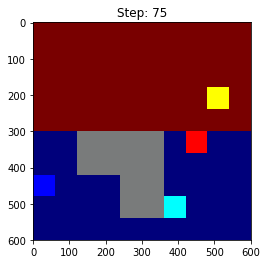

[[0.47220662 0.0161525  0.2310207  0.038441   0.24217916]]


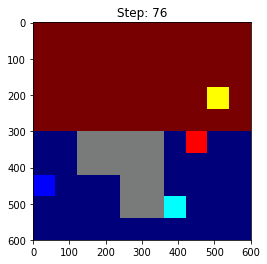

[[0.47220662 0.0161525  0.2310207  0.038441   0.24217916]]


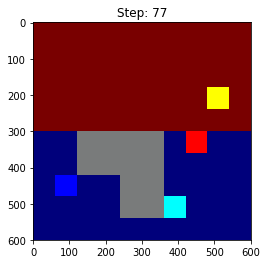

[[0.4703011  0.01137037 0.29888508 0.04484006 0.17460337]]


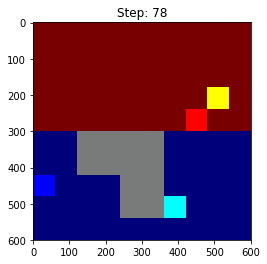

[[0.47636324 0.01709966 0.22677185 0.03923769 0.24052748]]


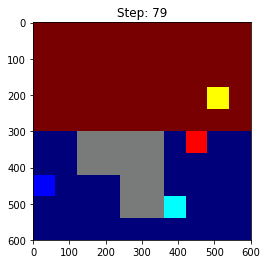

[[0.47220662 0.0161525  0.2310207  0.038441   0.24217916]]


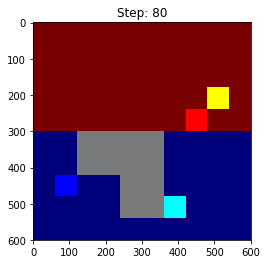

[[0.46764266 0.01173615 0.29314473 0.04663834 0.18083808]]


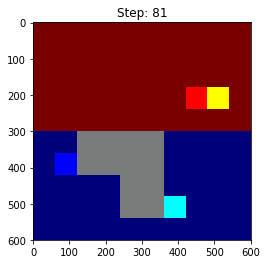

[[0.42286977 0.01772165 0.35664675 0.00897593 0.19378598]]


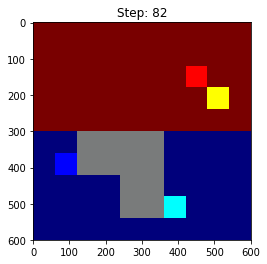

[[0.42376855 0.01726678 0.34931853 0.00878018 0.20086595]]


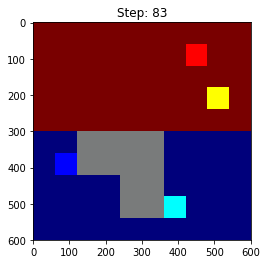

[[0.41845468 0.01839141 0.35065758 0.00894728 0.20354907]]


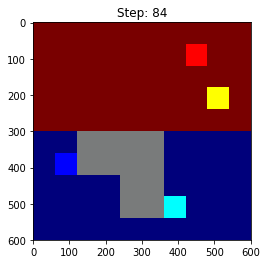

[[0.41845468 0.01839141 0.35065758 0.00894728 0.20354907]]


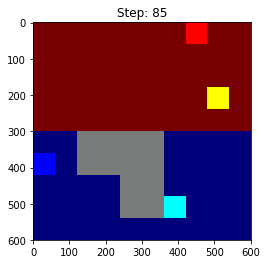

[[0.44538358 0.02453675 0.2535388  0.00808451 0.26845643]]


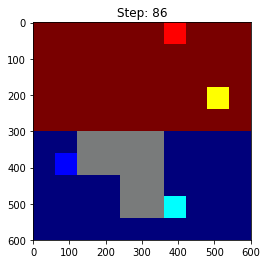

[[0.41721904 0.01830829 0.35710782 0.00829534 0.19906949]]


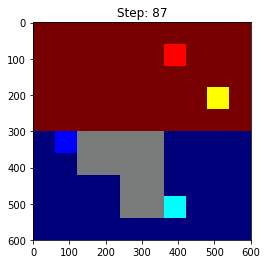

[[0.3904667  0.06769332 0.28251228 0.00265744 0.25667027]]


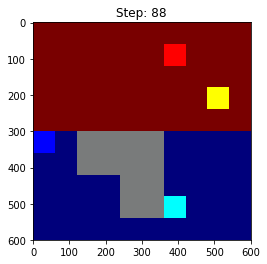

[[0.37821153 0.06310944 0.17341202 0.00251675 0.38275024]]


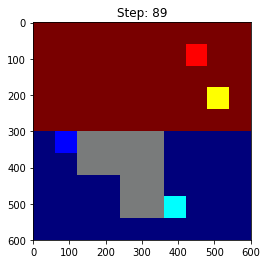

[[0.39484394 0.06698319 0.2669932  0.00271734 0.26846236]]


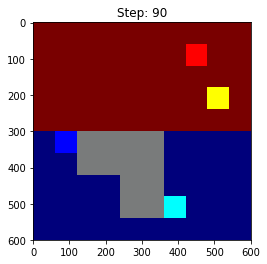

[[0.39484394 0.06698319 0.2669932  0.00271734 0.26846236]]


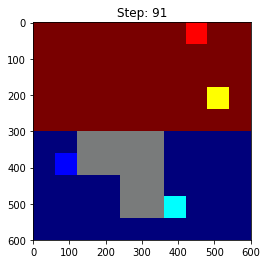

[[0.42382374 0.01741125 0.35258836 0.00837569 0.19780098]]


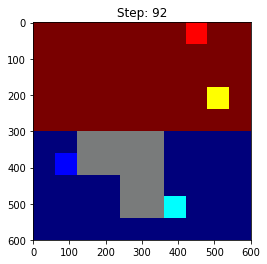

[[0.42382374 0.01741125 0.35258836 0.00837569 0.19780098]]


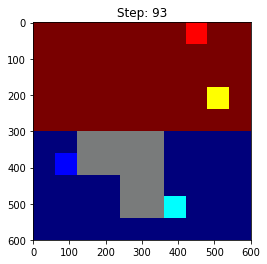

[[0.42382374 0.01741125 0.35258836 0.00837569 0.19780098]]


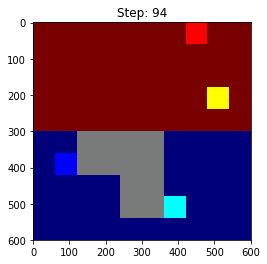

[[0.42382374 0.01741125 0.35258836 0.00837569 0.19780098]]


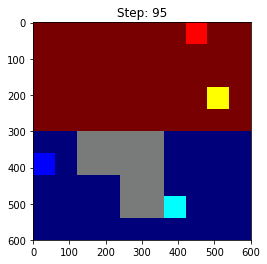

[[0.44538358 0.02453675 0.2535388  0.00808451 0.26845643]]


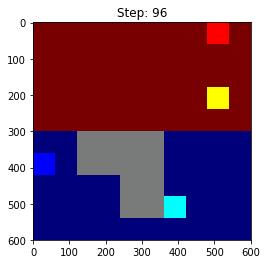

[[0.46040982 0.02098227 0.253383   0.00826506 0.25695992]]


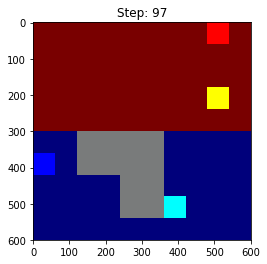

[[0.46040982 0.02098227 0.253383   0.00826506 0.25695992]]


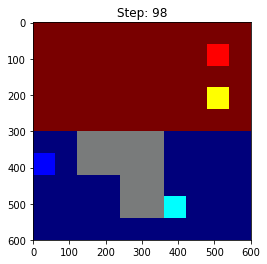

[[0.4590198  0.02413963 0.24869019 0.00859208 0.25955832]]


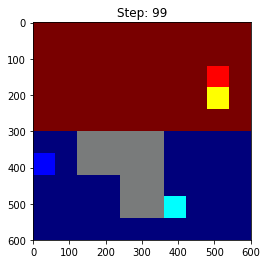

[[0.47495964 0.02231012 0.24801642 0.0087686  0.2459453 ]]


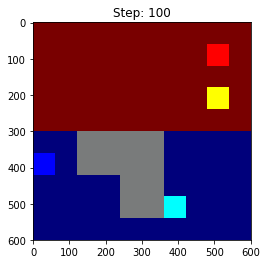

[[0.4590198  0.02413963 0.24869019 0.00859208 0.25955832]]


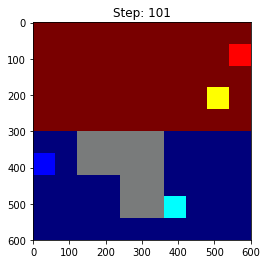

[[0.45438722 0.02339516 0.24911313 0.00855862 0.26454577]]


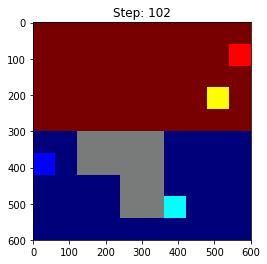

[[0.45438722 0.02339516 0.24911313 0.00855862 0.26454577]]


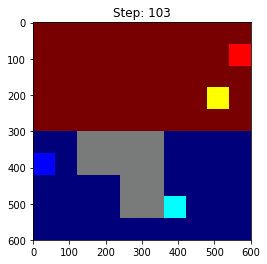

[[0.45438722 0.02339516 0.24911313 0.00855862 0.26454577]]


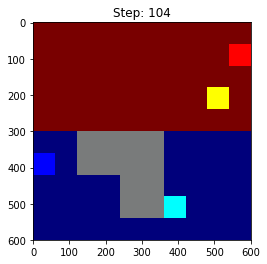

[[0.45438722 0.02339516 0.24911313 0.00855862 0.26454577]]


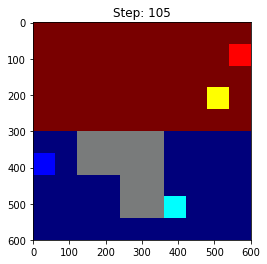

[[0.45438722 0.02339516 0.24911313 0.00855862 0.26454577]]


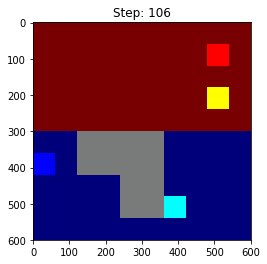

[[0.4590198  0.02413963 0.24869019 0.00859208 0.25955832]]


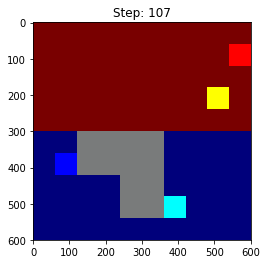

[[0.4249905  0.01813263 0.35970446 0.00875572 0.18841662]]


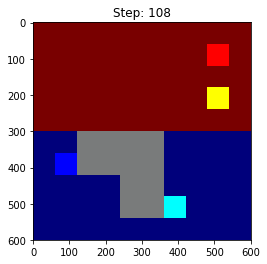

[[0.42178127 0.01835071 0.361407   0.00873599 0.18972506]]


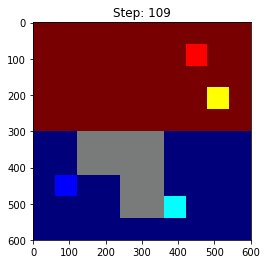

[[0.47135258 0.01175722 0.29042897 0.04509532 0.18136594]]


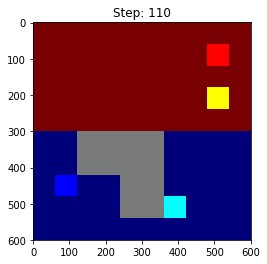

[[0.46414647 0.01232222 0.30172756 0.04349415 0.17830956]]


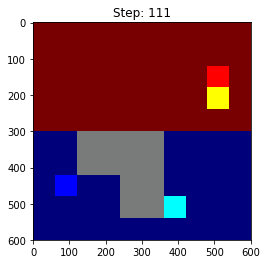

[[0.4721959  0.01219907 0.29475433 0.046242   0.17460875]]


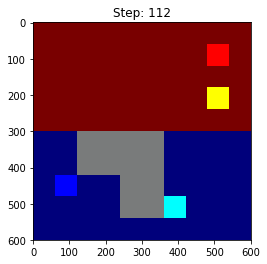

[[0.46414647 0.01232222 0.30172756 0.04349415 0.17830956]]


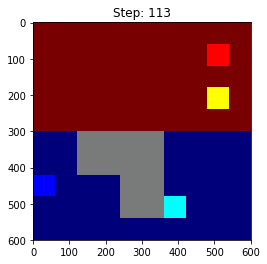

[[0.47625053 0.01526497 0.23068772 0.0383234  0.2394734 ]]


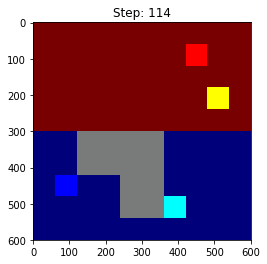

[[0.47135258 0.01175722 0.29042897 0.04509532 0.18136594]]


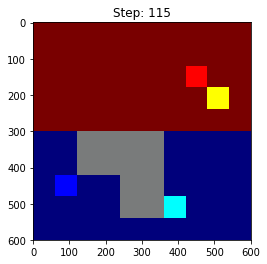

[[0.46895412 0.01187273 0.28648624 0.04683674 0.18585016]]


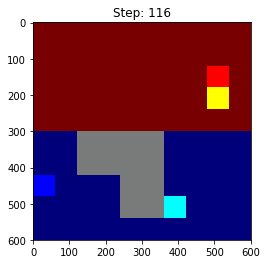

[[0.48641866 0.01713451 0.22236346 0.0403431  0.23374027]]


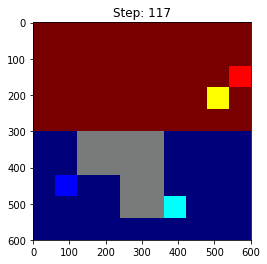

[[0.47867593 0.01204616 0.29044446 0.04687835 0.17195512]]


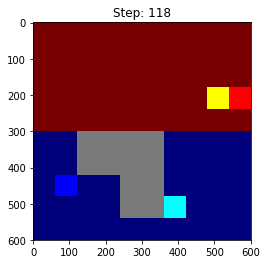

[[0.48645917 0.01126102 0.29174754 0.04610775 0.16442458]]


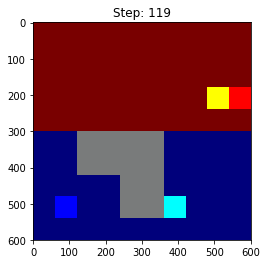

[[0.455551   0.02139324 0.2576514  0.13090904 0.13449535]]


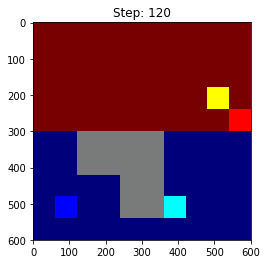

[[0.46348667 0.02065632 0.2554519  0.13459541 0.12580974]]


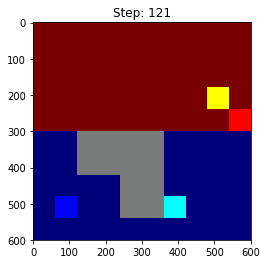

[[0.46348667 0.02065632 0.2554519  0.13459541 0.12580974]]


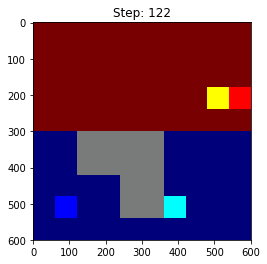

[[0.455551   0.02139324 0.2576514  0.13090904 0.13449535]]


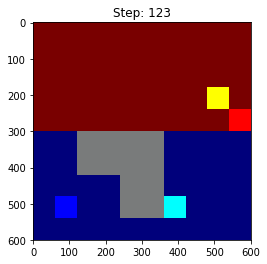

[[0.46348667 0.02065632 0.2554519  0.13459541 0.12580974]]


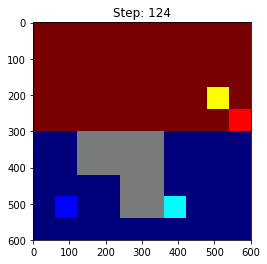

[[0.46348667 0.02065632 0.2554519  0.13459541 0.12580974]]


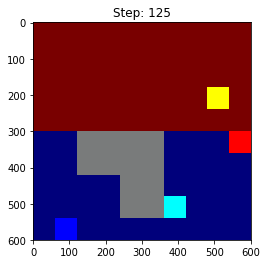

[[0.46510017 0.03869459 0.18436792 0.20759852 0.10423871]]


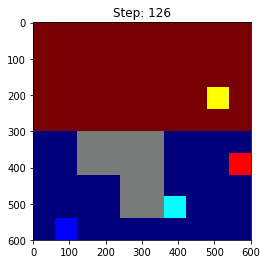

[[0.4624817  0.03966078 0.1870057  0.20426166 0.10659014]]


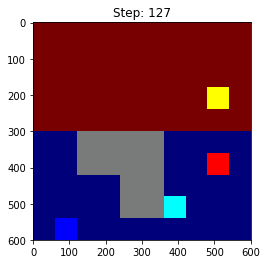

[[0.45738098 0.04010278 0.18869476 0.2056274  0.10819408]]


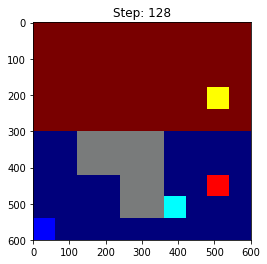

[[0.45255718 0.04308045 0.17270347 0.16496062 0.1666983 ]]


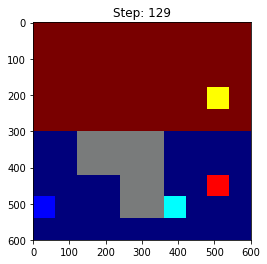

[[0.4404931  0.02668966 0.20400131 0.10768174 0.22113425]]


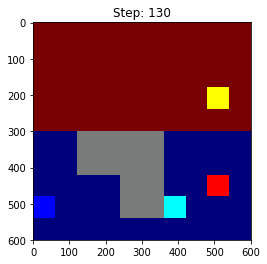

[[0.4404931  0.02668966 0.20400131 0.10768174 0.22113425]]


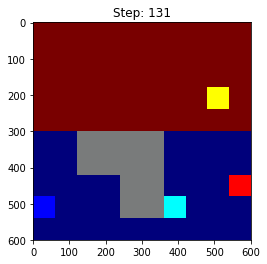

[[0.43979812 0.02677658 0.20641626 0.10574812 0.22126092]]


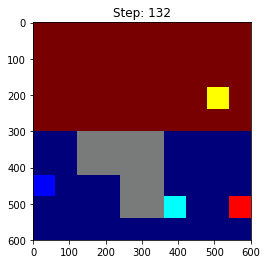

[[0.47394562 0.01703595 0.23207745 0.03890338 0.23803759]]


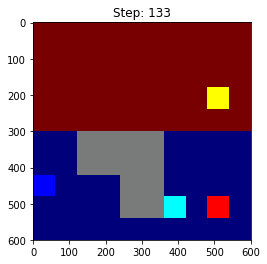

[[0.47991213 0.01654049 0.23064041 0.03705155 0.23585537]]


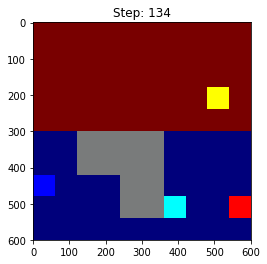

[[0.47394562 0.01703595 0.23207745 0.03890338 0.23803759]]


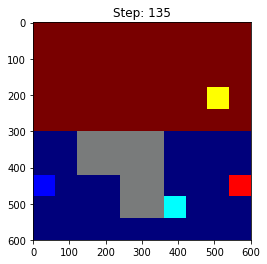

[[0.47917607 0.01627837 0.23133026 0.03916767 0.23404762]]


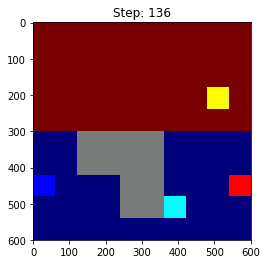

[[0.47917607 0.01627837 0.23133026 0.03916767 0.23404762]]


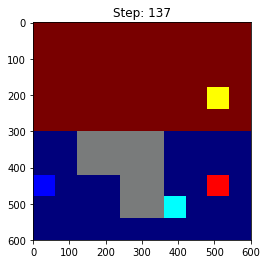

[[0.48338872 0.01664156 0.22966745 0.03858861 0.23171368]]


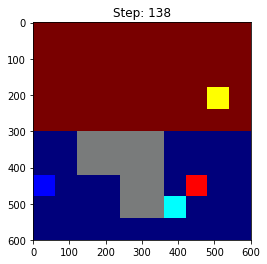

[[0.47230846 0.01655242 0.23299366 0.03852344 0.23962207]]


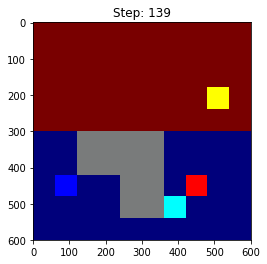

[[0.4742754  0.01135741 0.29798722 0.04404343 0.17233653]]


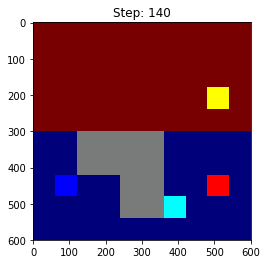

[[0.4693167  0.01161316 0.2962588  0.0444696  0.17834173]]


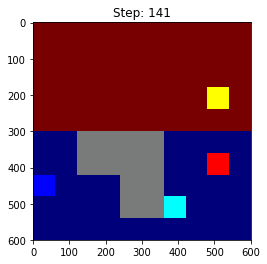

[[0.47840583 0.01610869 0.22725414 0.03875665 0.23947473]]


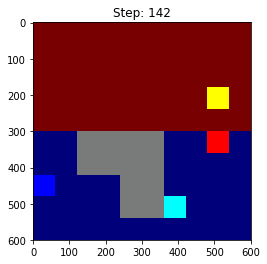

[[0.475313   0.01635849 0.23057188 0.03804903 0.23970768]]


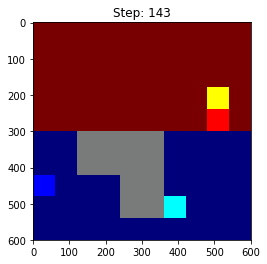

[[0.47540808 0.01628187 0.23042472 0.03851625 0.2393691 ]]


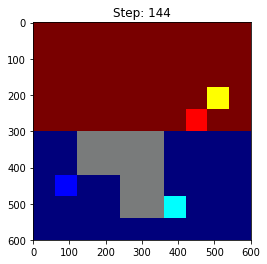

[[0.46764266 0.01173615 0.29314473 0.04663834 0.18083808]]


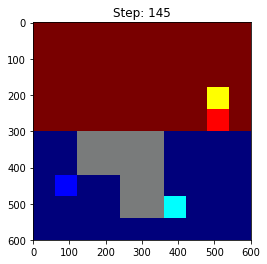

[[0.47333074 0.01210089 0.2951126  0.04577412 0.17368163]]


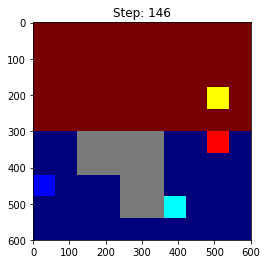

[[0.475313   0.01635849 0.23057188 0.03804903 0.23970768]]


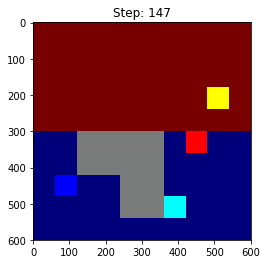

[[0.4703011  0.01137037 0.29888508 0.04484006 0.17460337]]


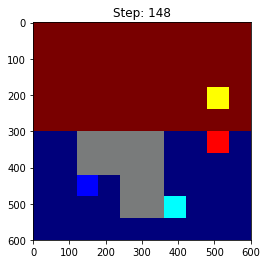

[[0.40975595 0.01058194 0.39733768 0.04337544 0.13894896]]


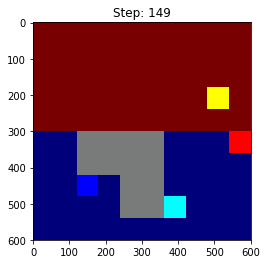

[[0.4140647  0.01076151 0.39404058 0.0420941  0.13903907]]


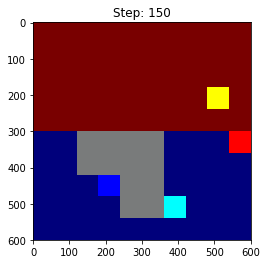

Time: 115.88 s, rscore: -75.00


In [19]:
#After each step
def show_state(env, step=0):
    plt.figure()
    plt.clf()
    plt.imshow(env.render(mode='rgb_array'))
    plt.title("Step: %d" % (step))

    plt.pause(0.05)  # pause for plots to update
try:
    start_time = time.time()
    #env.seed(1)
    s = env.reset(map_size=10, policy_red=policy_red)
    
    total_reward = 0
    prev_reward=0
    frame=0
    for frame in range(max_ep+1):
        obs = one_hot_encoder2(env._env, env.get_team_blue)
        act_prob = sess.run(myAgent.output, feed_dict={myAgent.state_input:obs})
        print(act_prob)
        act = [np.random.choice(action_space, p=act_prob[x]/sum(act_prob[x])) for x in range(n_agent)]
        s,r1,d,_ = env.step(act)
        r = r1-prev_reward
        if frame == max_ep and d == False:
            r = -100
            r1 = -100
        total_reward += r
        # render and sleep are not needed for score analysis
        
        show_state(env, frame)
        prev_reward = r1
        if d:
            break

    print("Time: %.2f s, rscore: %.2f" %
        ((time.time() - start_time),total_reward))
    
except KeyboardInterrupt:
    print('\n\nManually stopped the running (KeyboardInterrupt)');